# SLATE DEMO ON A TOY GRAPH 

In this notebook we present the three first step of SLATE  : 
a.) SupraAdjacency Matrix construction 
b.) Spatio-Temporal encoding with projection on the toy graph for visualising 
c.) How we construct the token matrix for the Transformer

In [16]:
import os 
import pickle 
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import torch
from scipy.sparse.linalg import eigsh



## Visualize the initial graph DTDG
A typical DTDG with three snapshots, and 10 nodes per snapshot. We see that it contains isolated nodes as well as multiple connected component per snapshot.

In [17]:
if os.path.exists('toy_dataset.gpickle'):
    with open('toy_dataset.gpickle', 'rb') as f:
        sup_G = pickle.load(f)
    G1 = nx.Graph()
    G2 = nx.Graph()
    G3 = nx.Graph()

    for e in sup_G.edges:
        u,v = e
        if u < 10: 
            G1.add_edge(u,v)
        elif u < 20:
            G2.add_edge(u-10,v-10)
        else:
            G3.add_edge(u-20,v-20)

if os.path.exists('toy_dataset_layout.pkl'):
    with open('toy_dataset_layout.pkl','rb') as f:
        new_fixed_layout = pickle.load(f)

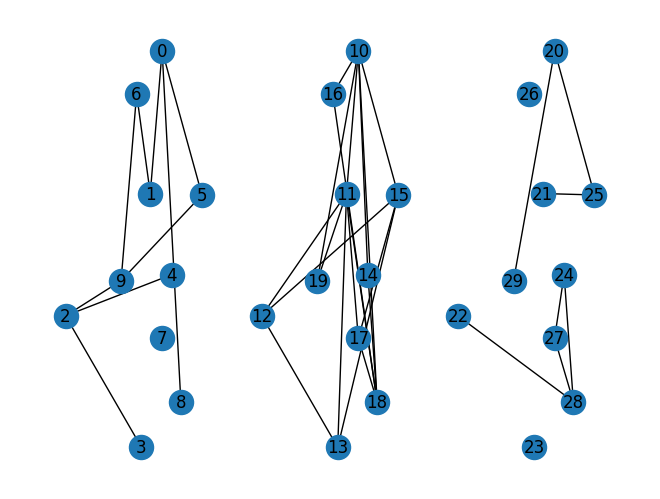

In [18]:
nx.draw(sup_G, pos=new_fixed_layout, with_labels=True)

In [19]:
adj_matrix_1 = torch.zeros((10,10))
adj_matrix_2 = torch.zeros((10,10))
adj_matrix_3 = torch.zeros((10,10))
for e in G1.edges:
    u,v = e
    adj_matrix_1[u,v] = 1
    adj_matrix_1[v,u] = 1

for e in G2.edges:
    u,v = e
    adj_matrix_2[u,v] = 1
    adj_matrix_2[v,u] = 1

for e in G3.edges:
    u,v = e
    adj_matrix_3[u,v] = 1
    adj_matrix_3[v,u] = 1

## a.) From DTDG to MultiLayer Graph : supra-adjacency matrix (SLATE Fig 2)

In [20]:
import torch
from torch_geometric.utils import to_undirected
from slate.datasets import Discrete_graph

In [21]:
# Convert networkx into pytorch geometric data used in SLATE
T = 3
N = 10 
edge_index1 = adj_matrix_1.nonzero().t().contiguous()
edge_index2 = adj_matrix_2.nonzero().t().contiguous()
edge_index3 = adj_matrix_3.nonzero().t().contiguous()
x = torch.eye(N+1)
time1 = torch.zeros(len(edge_index1[0]))
time2 = torch.ones(len(edge_index2[0]))
time3 = 2*torch.ones(len(edge_index3[0]))
weights1 = torch.ones(len(edge_index1[0]))
weights2 = torch.ones(len(edge_index2[0]))
weights3 = torch.ones(len(edge_index3[0]))

# create a list of DiscreteGraph objects 

dg1 = Discrete_graph(edge_index1,weights1,time1,x,None)
dg2 = Discrete_graph(edge_index2,weights2,time2,x,None)
dg3 = Discrete_graph(edge_index3,weights3,time3,x,None)
graphs = [dg1,dg2,dg3]

### Graph to supra-adjacency matrix: Proposed SLATE Transformation 

In [22]:
# SLATE SETTINGS 
add_time_connection = True # Add temporal connection between identical nodes in different snapshots
remove_isolated = True # Remove isolated nodes in the supra graph
add_vn = True # Add a virtual node connected to all nodes in the snapshot
num_nodes = 10
# Function to convert a list of DiscreteGraph objects into a connected supra graph
# Same function used in dgt.lib.supra
 


num_graphs = len(graphs)
edge_index = []
edge_weight = []
l_id_vn = []
# Supra graph creation

for i in range(num_graphs): 
    ei = graphs[i].edge_index + i * num_nodes # IMPORTANT: We considere nodes in different snapshots as different nodes
    ew = graphs[i].edge_weight
    
    if add_vn:
        id_vn = num_nodes*num_graphs + i # Assign an id to the virtual node
        l_id_vn.append(id_vn) # Necessary to identify the virtual node
        nodes_snapshot = torch.unique(ei.view(-1)) # Get the connected nodes in the snapshot
        # Add connections between the virtual node and the nodes (deg > 0) in the snapshot
        # We do not connect the virtual node to isolated nodes
        vn_connections = torch.cat((torch.tensor([id_vn]*len(nodes_snapshot)).view(1,-1),nodes_snapshot.view(1,-1)),dim=0)
        ei = torch.cat((ei,vn_connections),dim=1)
        ew = torch.cat((ew,torch.ones(len(nodes_snapshot))))
        
    if add_time_connection: 
        # Add temporal connections between identical nodes in different snapshots
        if i < num_graphs - 1:
            ei_i = graphs[i].edge_index 
            ei_next = graphs[i+1].edge_index 
            nodes_snapshot = torch.unique(ei_i.view(-1))
            nodes_snapshot_next = torch.unique(ei_next.view(-1))
            # Intersection 
            common_nodes = torch.LongTensor(np.intersect1d(nodes_snapshot,nodes_snapshot_next))
            # Add temporal connections
            src = common_nodes + i*num_nodes
            dst = common_nodes + (i+1)*num_nodes
            time_co = torch.vstack((src,dst))
            ei = torch.cat((ei,time_co),dim=1)
            ew = torch.cat((ew,torch.ones(len(common_nodes))))
            
            
    edge_index.append(ei)
    edge_weight.append(ew)
edge_index = torch.cat(edge_index,dim=1)
edge_weight = torch.cat(edge_weight)

# Now we have to create a mask to remove the isolated nodes
total_nodes = num_nodes * num_graphs + num_graphs if add_vn else num_nodes * num_graphs
mask = torch.zeros(total_nodes)
mask[torch.unique(edge_index)] = 1
# Indices of isolated nodes
isolated_nodes = torch.where(mask == 0)[0]
print('Isolated Nodes',isolated_nodes)
print('Virtual nodes',l_id_vn)

# Make the graph undirected
edge_index, edge_weight = to_undirected(edge_index,edge_weight)
edge_weight = torch.ones(edge_index.size(1))
# We return the edge_index, edge_weight, and the mask list of isolated nodes


Isolated Nodes tensor([ 7, 23, 26])
Virtual nodes [30, 31, 32]


### We plot the Transformed SupraGraph

In [23]:
print(total_nodes)
sup_G_adj = np.zeros((total_nodes,total_nodes))
for i in range(edge_index.shape[1]):
    u,v = edge_index[:,i]
    sup_G_adj[u,v] = 1
    sup_G_adj[v,u] = 1

33


In [24]:
transform_sup_G = nx.from_numpy_array(sup_G_adj)

In [25]:
layout_transform_sup_G = new_fixed_layout.copy()

In [26]:
layout_transform_sup_G[30] = np.array([-0.8,0.11])
layout_transform_sup_G[31] = np.array([1.60,0.11])
layout_transform_sup_G[32] = np.array([3.90,0.11])


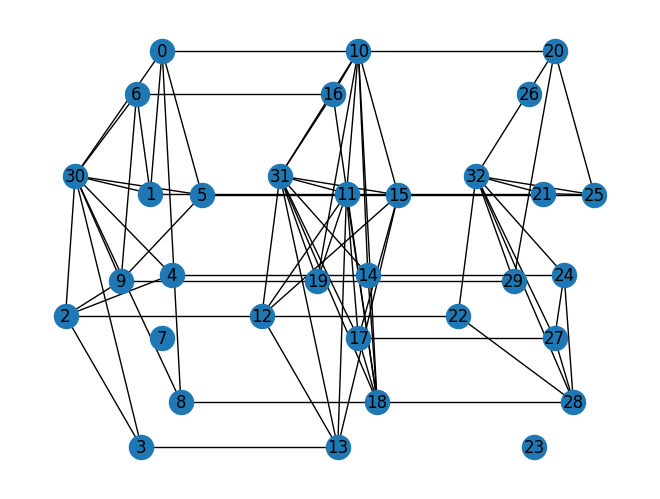

In [27]:
nx.draw(transform_sup_G, pos=layout_transform_sup_G, with_labels=True)

#### Important in the supragraph there's no more isolated nodes (23 - 7 - 26)

## b.) Compute spatio-temporal encoding (SLATE Fig 2  )

We have our edge index and the mask of the isolated nodes for the new graph 

In [28]:

from slate.lib import  reindex_edge_index, AddSupraLaplacianPE 
import torch.nn as nn

In [29]:
new_edge_index = reindex_edge_index(edge_index) # Reindex the edge index to remove isolated nodes, Necessary to compute eigenvalues
num_nodes_supra = len(torch.unique(new_edge_index[0]))
len(torch.unique(new_edge_index)) == total_nodes - len(isolated_nodes)

True

In [30]:
# SLATE EXAMPLE SETTINGS
k = 6
dim_embedding = 4
normalization = 'sym'

supralaplacianPE = AddSupraLaplacianPE(k=k,
                                      normalization=normalization,
                                      is_undirected=True,
                                      add_eig_vals=False)
embed_nodes = nn.Embedding(N+1,embedding_dim=dim_embedding)


In [31]:
pe  = supralaplacianPE(edge_index=new_edge_index, edge_weight=edge_weight, num_nodes=num_nodes_supra)


In [32]:
# Add the positional encoding to the isolated nodes (0)
all_pe = torch.zeros((total_nodes,k))
all_pe[mask == 1] = pe

### Token construction : The token is composed of node embedding and a spatio-temporal encoding 

In [33]:
node_embedding = embed_nodes(torch.arange(N+1)) 
tokens = node_embedding[:-1,:].repeat(T,1) # We consider same node in different snapshots as different nodes
vn_emb = node_embedding[-1].repeat(T,1)
# cat the tokens of the nodes and the num_graphs virtual nodes
tokens = torch.cat((tokens,vn_emb),dim=0) # Add the virtual nodes at the end of the tokens

In [34]:
# Add the positional encoding to the tokens
tokens = torch.cat((tokens,all_pe),dim=1)

In [35]:
tokens.shape # (num_nodes * num_graphs + num_graphs, dim_embedding + k)

torch.Size([33, 10])

### Visualisation of Spatio-Temporal encoding 

Before Linear Transformation we'll plot the spatio-temporal encoding on the supragraph 

In [36]:
from matplotlib.colors import LinearSegmentedColormap
def plot_supragraph_laplacian(transform_sup_G,vec_propre,layout_transform_sup_G):
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", ["purple", "white", "green"], N=256)
    fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure and an axes
    nx.draw(transform_sup_G, pos=layout_transform_sup_G, node_color=vec_propre, cmap=cmap, vmin=-1, vmax=1,edgecolors='black', with_labels=True, ax=ax,node_size=800)
    
    # Create a ScalarMappable object
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
    sm.set_array([])
    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax, orientation='vertical')  # Use the axes for the colorbar

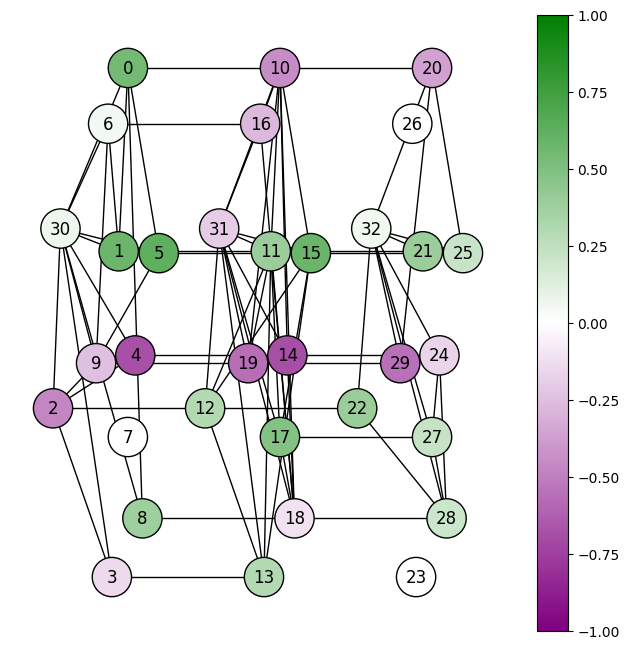

In [37]:
plot_supragraph_laplacian(transform_sup_G,all_pe[:,4],layout_transform_sup_G)

### Linear step before transformer

In [38]:
lin_transform = nn.Linear(dim_embedding + k , dim_embedding)
tokens = lin_transform(tokens)

## c.) Transformer step (SLATE Fig 2 )

In [39]:
norm = nn.LayerNorm(dim_embedding)
encoder_layer = nn.TransformerEncoderLayer(d_model = dim_embedding,
                                            nhead=2,
                                            dim_feedforward=24,
                                            batch_first=True,
                                            norm_first=True,
                                            )     
    
spatio_temp_attn = nn.TransformerEncoder(encoder_layer,
                                            num_layers = 1,
                                            norm = norm)

In [40]:
embed_token = spatio_temp_attn(tokens.unsqueeze(0)).squeeze() # dim = [1,T*(N+1),d] ;  N+1 because we add the virtual node
# We remove the virtual nodes, because we don't need them for prediction
final_emb = embed_token[:-T]
final_emb = final_emb.view(N,T,dim_embedding)

In [41]:
final_emb.shape # 10 nodes with 3 timestamps and 4 emb dimensions

torch.Size([10, 3, 4])